In [141]:
import os
import glob
import pickle

import tensorflow as tf
import numpy as np
from drift.robots import ETHModel
from collections import deque
from drift.models.ddpg import DDPG, DDPGParams, DDPGSummary
from drift.commons import ParamsBase
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.transforms import Affine2D
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt.plots import plot_convergence, plot_evaluations, plot_objective
import seaborn as sns

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.logging.set_verbosity(tf.logging.ERROR)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [76]:
def analyse(ddpg, eth, params):
    dt = 0
    # deque sequence for stacking states
    state_sequence = deque(
        [np.zeros(params.state_dim) for _ in range(params.stack_len)],
        maxlen=params.stack_len
    )
    inf_reward = []
    eth.reset()

    while dt < params.drive_dur:
        current_state = eth.get_state().to_array()
        state_sequence.append(current_state)

        ss = state_sequence.copy()
        ss.reverse()
        cs = np.array(ss).ravel().reshape(1, -1)
        action = (ddpg.predict(cs) + 0).ravel()[0]
        _, _, reward, _, _ = eth(action, duty_cycle=1)
        inf_reward.append(reward)

        dt += eth.variables.dt

        eth.sequence(eth.variables.group)

    eth.inf_reward = np.array(inf_reward)
    
    return eth


def load_eth_model(params):
    eth = ETHModel(
        imp=params.dynamics,
        reward_version=params.reward_version,
        ds=params.ds,
        reward_params=params.reward_params
    )
    return eth


def _m(path):
    """Join base path with path to model"""
    return os.path.join("/home/zadiq/dev/@p/auto_drift/data", path)


def score_model(eth, output=True):
    t_reward = eth.inf_reward.sum()
    max_reward = eth.inf_reward.max()
    mean_reward = eth.inf_reward.mean()
    scores = {
        "Total Reward: ": t_reward,
        "Max Reward: ": max_reward,
        "Mean Reward: ": mean_reward,
    }
    if output:
        print(scores)
    return scores

def find_optimal_dyn(ddpg, eth, d_params):
    dynamics = [
        Integer(6, 10, name="B"),
        Real(8, 11, name="C"),
        Integer(500, 4000, name="D"),

        Integer(750, 1500, name="Cm1"),
        # Categorical([1, 3, 5, 7, 9, 11, 13, 15, 17], name="Cm2"),
        Integer(1, 17, name="Cm2"),
        Integer(50, 150, name="Cr"),
        Integer(30, 60, name="Cd"),
    ]
    dynamic_labels = [
        'B', 'C', 'D', 'Cm1', 'Cm2', 'Cr', 'Cd'
    ]
    count = 0
    
    @use_named_args(dynamics)
    def run_inference(**params):
        eth.reset()
        eth.variables.__dict__.update(params)
        analyse(ddpg, eth, d_params)

        #  negate to turn reward into cost
        cost = -1 * np.array(eth.inf_reward).sum()
        if np.isnan(cost):
            cost = 2000

        print(f"{cost}")
        return cost
    
    gp = gp_minimize(
        run_inference,
        dynamics,
        n_calls=200, n_jobs=2,
        random_state=42,
    )
    return gp

In [7]:
model_base_paths = [
    "26-02-2019/ddpg_run_3",
    "02-03-2019/ddpg_run_1",
    "02-03-2019/ddpg_run_2",
    "02-03-2019/ddpg_run_3",
    "02-03-2019/ddpg_run_5",
    "02-03-2019/ddpg_run_6",
    "02-03-2019/ddpg_run_7",
]

## Control Robustness
using model ddpg_run_7 episode 41 to control other models that it has not been trained on

In [6]:
class Params(DDPGParams, ParamsBase):
    """Params class"""
    # path to base path containing models and params.json
    base_path = "/home/zadiq/dev/@p/drift_project/data/02-03-2019/ddpg_run_7"

    # the episode of the model that will be inferred
    episode = 41

In [8]:
tf.reset_default_graph()
with tf.Session() as sess:
    params = Params()
    ddpg = DDPG(params, sess)
    summary = DDPGSummary(sess)
    sess.run(tf.global_variables_initializer())

    # load and restore weights
    model_path = os.path.join(
        params.base_path, "model",
        f"eps-{params.episode}*"
    )
    model_path = glob.glob(model_path)[0].split(".")
    model_path = ".".join(model_path[:2])
    summary.load_model(model_path)
    
    for m_path in model_base_paths:
        params = Params.from_json(_m(m_path))
        eth = load_eth_model(params)
        eth = analyse(ddpg, eth, params)
        print(f"{m_path}\t|\t{eth.inf_reward.sum()}")

26-02-2019/ddpg_run_3	|	-144.6274331524827
02-03-2019/ddpg_run_1	|	-1999.9966771788029
02-03-2019/ddpg_run_2	|	-144.6274331524827
02-03-2019/ddpg_run_3	|	-1999.9966771788029
02-03-2019/ddpg_run_5	|	-392.1356601125526
02-03-2019/ddpg_run_6	|	-1999.9966771788029
02-03-2019/ddpg_run_7	|	-177.304151873007


## Optimal Dynamic Parameter
search for the optimal dynamic parameter that ddpg_run_7 episode 41 can control

In [15]:
tf.reset_default_graph()
with tf.Session() as sess:
    params = Params()
    ddpg = DDPG(params, sess)
    summary = DDPGSummary(sess)
    sess.run(tf.global_variables_initializer())

    # load and restore weights
    model_path = os.path.join(
        params.base_path, "model",
        f"eps-{params.episode}*"
    )
    model_path = glob.glob(model_path)[0].split(".")
    model_path = ".".join(model_path[:2])
    summary.load_model(model_path)
    
    params = Params.from_json(_m("02-03-2019/ddpg_run_7"))
    eth = load_eth_model(params)
    gp = find_optimal_dyn(ddpg, eth, params)

1999.9999994444117
2000
1999.9649356069533
1999.8266290027511
1948.1657630030882
2000
1939.2305118607053
288.99147234209795
227.78499589564018
1999.8840251327401
1999.999999022302
776.5126862830245
1999.9999974856241
1996.9380307903261
101.75785992001528
522.9850694881816
1132.6463725477329
1999.9999997046489
258.7845447881318
411.9711207018818
622.0062467399608
1999.9947432732683
405.64167523556614
120.65252332185125
676.8515450002603
662.5446838500654
223.01570436878302
123.25155622636865
1999.9985409868757
1999.9978231819694
1815.6345925257854
1999.9974183262407
134.23226987496315
1999.9962229190755
1999.9999974407901
1999.993560537604
1999.9999268528957
938.5188337106465
1999.9987944464099
1999.9927172399007
1840.0891549095477
1999.919283091273
199.40739496335576
145.1550644220386
1999.9961090417505
1999.9963238185503
1999.9834026711278
1999.998917377019
278.0863824012274
1999.999989392095
585.1765390709734
1591.3319941426903
943.2189051544888
1999.8286189658925
1999.9999994035456


/home/zadiq/dev/venvs/dl/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


395.09409684620744
1999.9945267273465
251.6767718693032
247.32905912257706
1999.9904521660155
113.06304556184716
1999.9888903662732
1999.9992351987917
150.98296487359127
171.6274261448173
1999.995171611639
1999.9967433563681
1999.996296767932


/home/zadiq/dev/venvs/dl/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


96.1277215148024
1872.3162962264335
1999.9980476697947
251.6710813429121
270.6623950270919
395.0895548174648
250.8811570731668
1999.9735411005622
255.0585606804054
1999.999784397763
1999.996156797582
242.71748764202644
395.09267461656236
350.90674600806415
96.13072489970556
323.87487798057447
1999.99808550243
229.73403175405338
1999.9942534363308
442.59573455518387
243.0675190885469
1999.9999947683953
1999.9956120740853
487.0002821112425
276.4182340991793
97.5014801154016
1999.9956326286851
197.50553202259655
96.08080403307676
287.1496391741754
1999.9958196149898
1999.9995030059167
2000
1999.275018833514
1999.9990647158334
2000
1999.999999371126
1999.9985369930735
1999.9987779526116
1999.9995268011742
265.9424405418458
1994.920130271989
1965.2105847741896
1976.11800093323
1999.9938316429657
1999.9999982025138
1999.9999749758895
380.75520916485755
750.8097409848981
2000
209.96723893623172


In [177]:
font = {'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)

/home/zadiq/dev/venvs/dl/lib/python3.6/site-packages/seaborn/distributions.py:679: UserWarning: Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.
  warnings.warn(warn_msg, UserWarning)


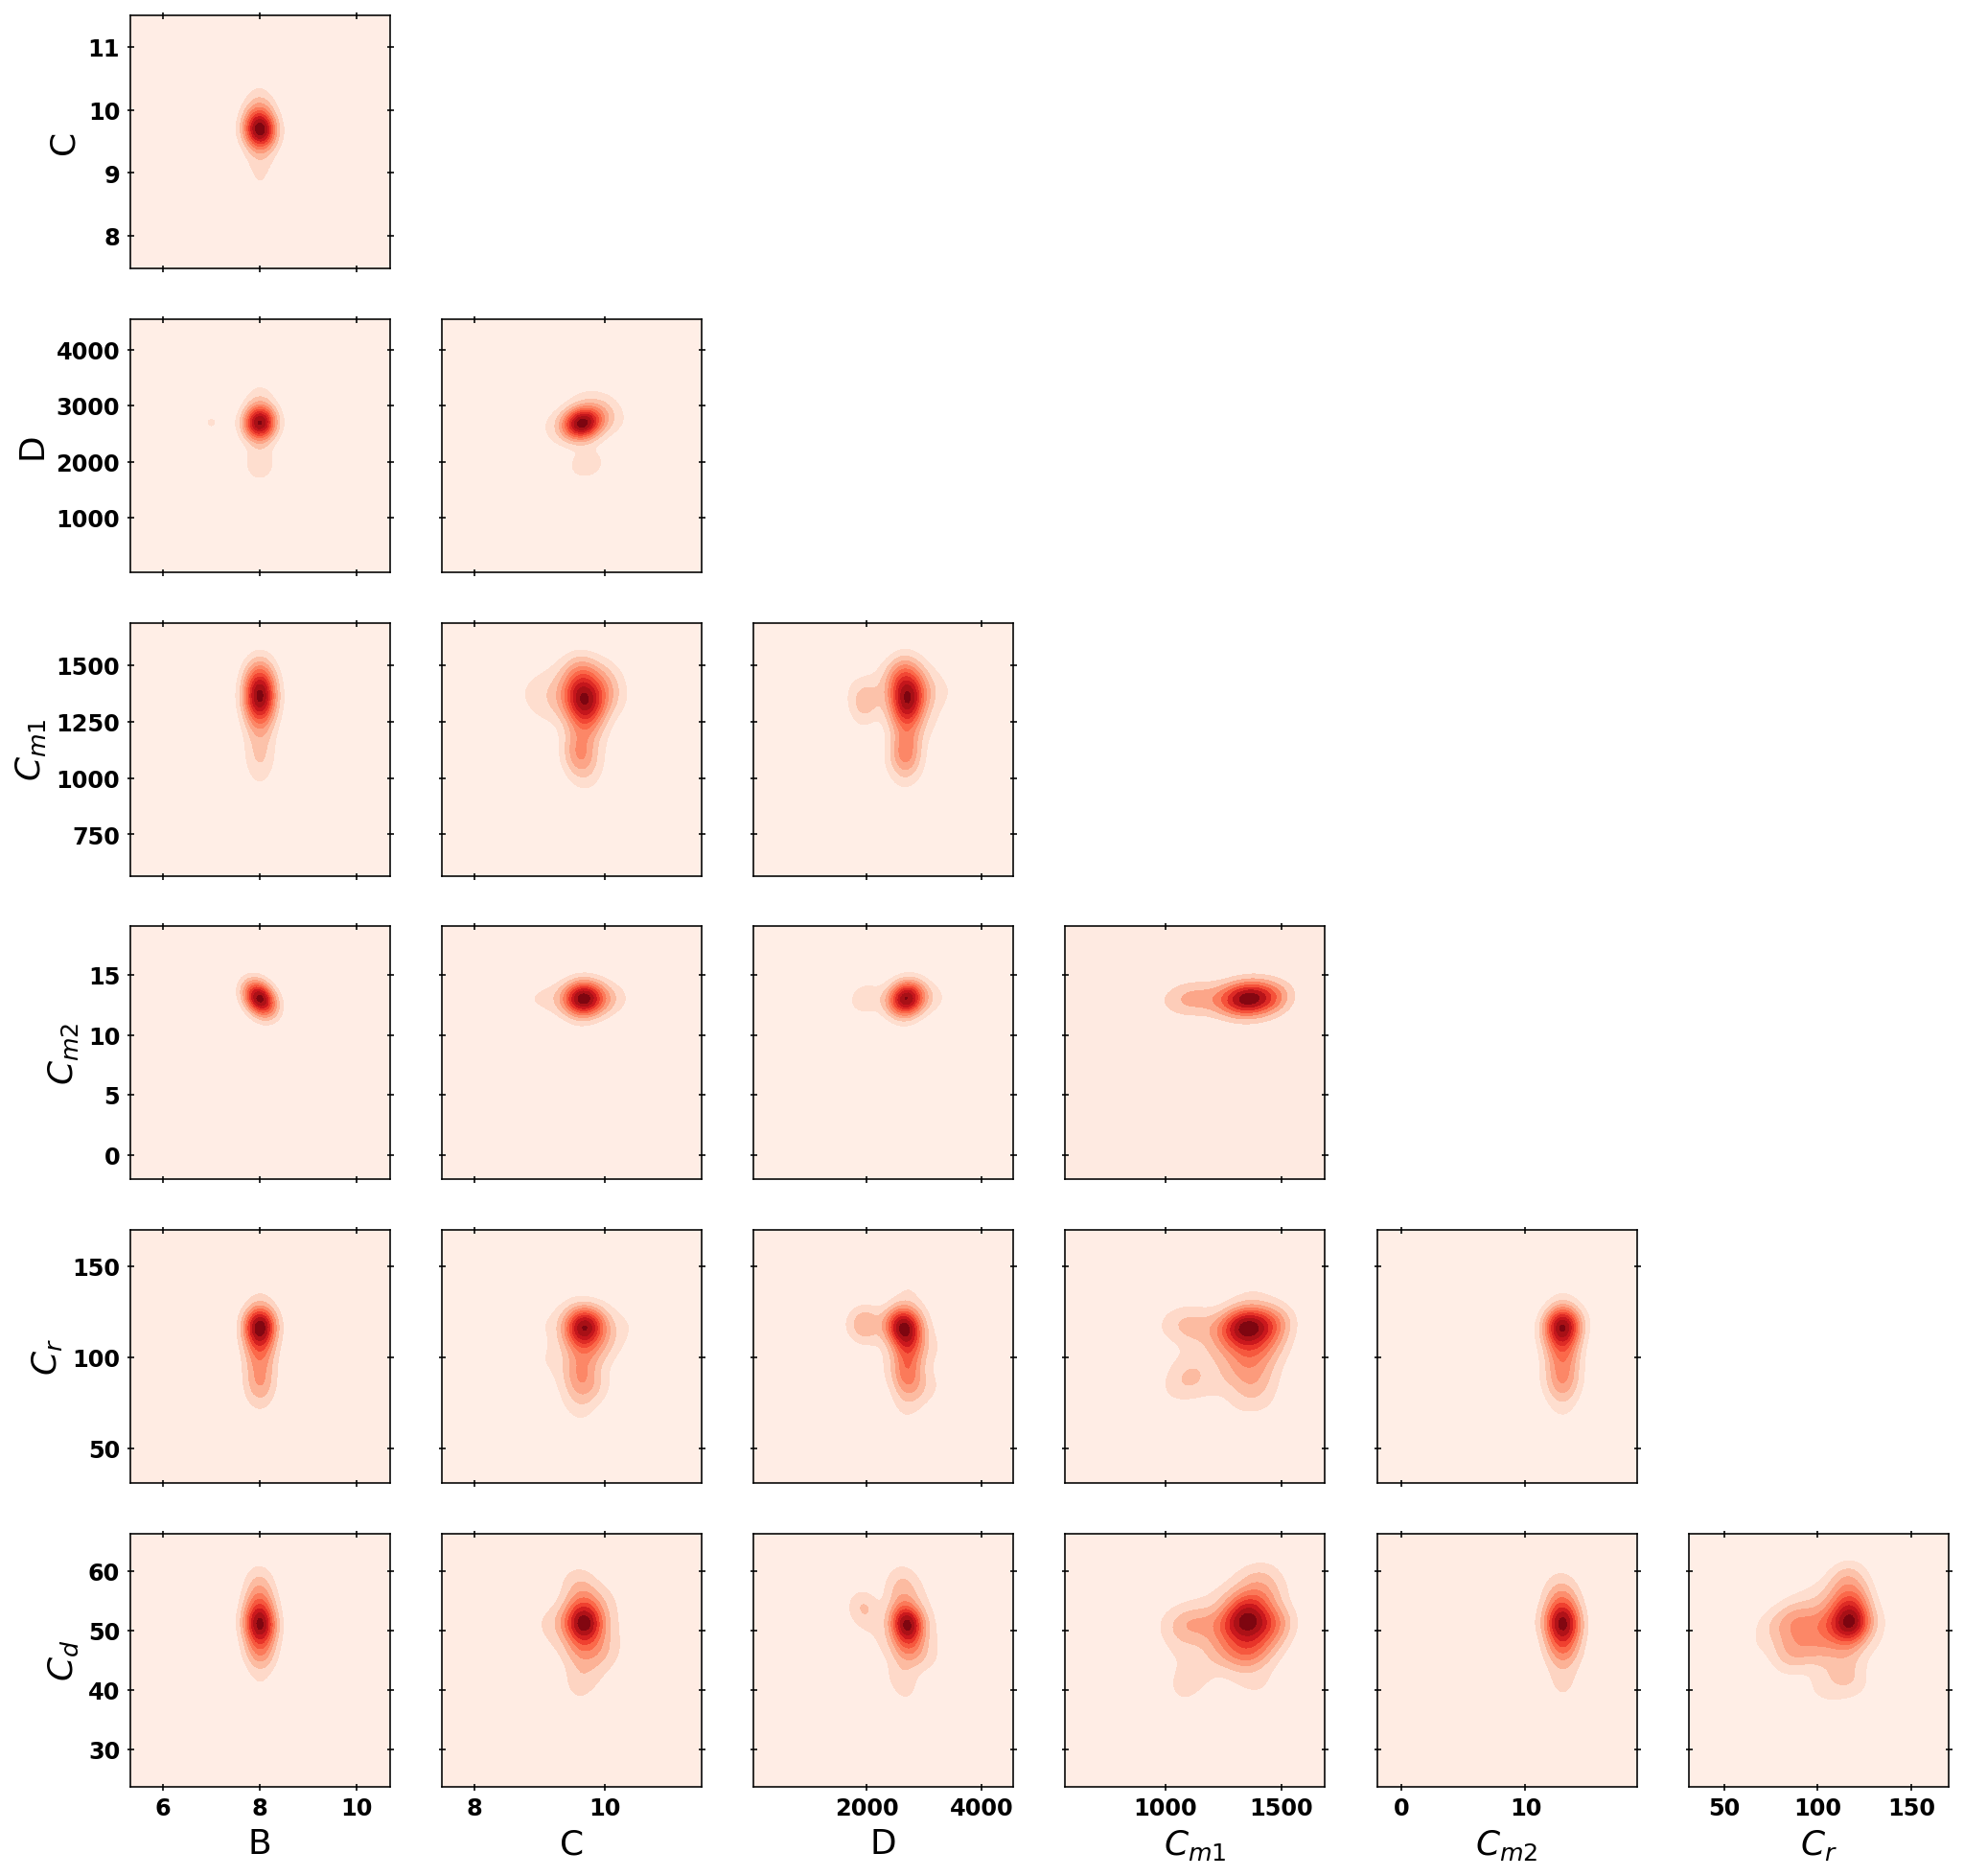

In [182]:
labels = ['B', 'C', 'D', '$C_{m1}$', '$C_{m2}$', '$C_{r}$', '$C_{d}$']
#         0     1    2    3           4           5          6
plot_ind =[
    [(1, 0),], # (y, x)
    [(2, 0), (2, 1)],
    [(3, 0), (3, 1), (3, 2)],
    [(4, 0), (4, 1), (4, 2), (4, 3)],
    [(5, 0), (5, 1), (5, 2), (5, 3), (5, 4)],
    [(6, 0), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5)],
]
rc = len(labels)-1
fig, axes = plt.subplots(rc, rc, figsize=(17, 17))

#
for i, (ind, ax_row) in enumerate(zip(plot_ind, axes)):
    ax_len = len(ind)
    [fig.delaxes(x) for x in ax_row[ax_len:]]
    for j, (sub, ax) in enumerate(zip(ind, ax_row)):
        y = np.array(gp.x_iters)[:, sub[0]]
        x = np.array(gp.x_iters)[:, sub[1]]
        
        ax.xaxis.set_ticks_position('both')
        ax.yaxis.set_ticks_position('both')        
        ax.tick_params('both', direction='inout')
        
        if i < rc-1:
            ax.set_xticklabels([])
        
        if j > 0:
            ax.set_yticklabels([])
        
        if j == 0:
            ax.set_ylabel(labels[sub[0]], size=18)
        
        if i == rc-1:
            ax.set_xlabel(labels[sub[1]], size=18)
            
        sns.kdeplot(data=np.array([x, y]).T, ax=ax, cmap="Reds", shade=True)

# fig.tight_layout()
fig.savefig(f"images/optimal_dyno_search.eps", format="eps", dpi=1000)

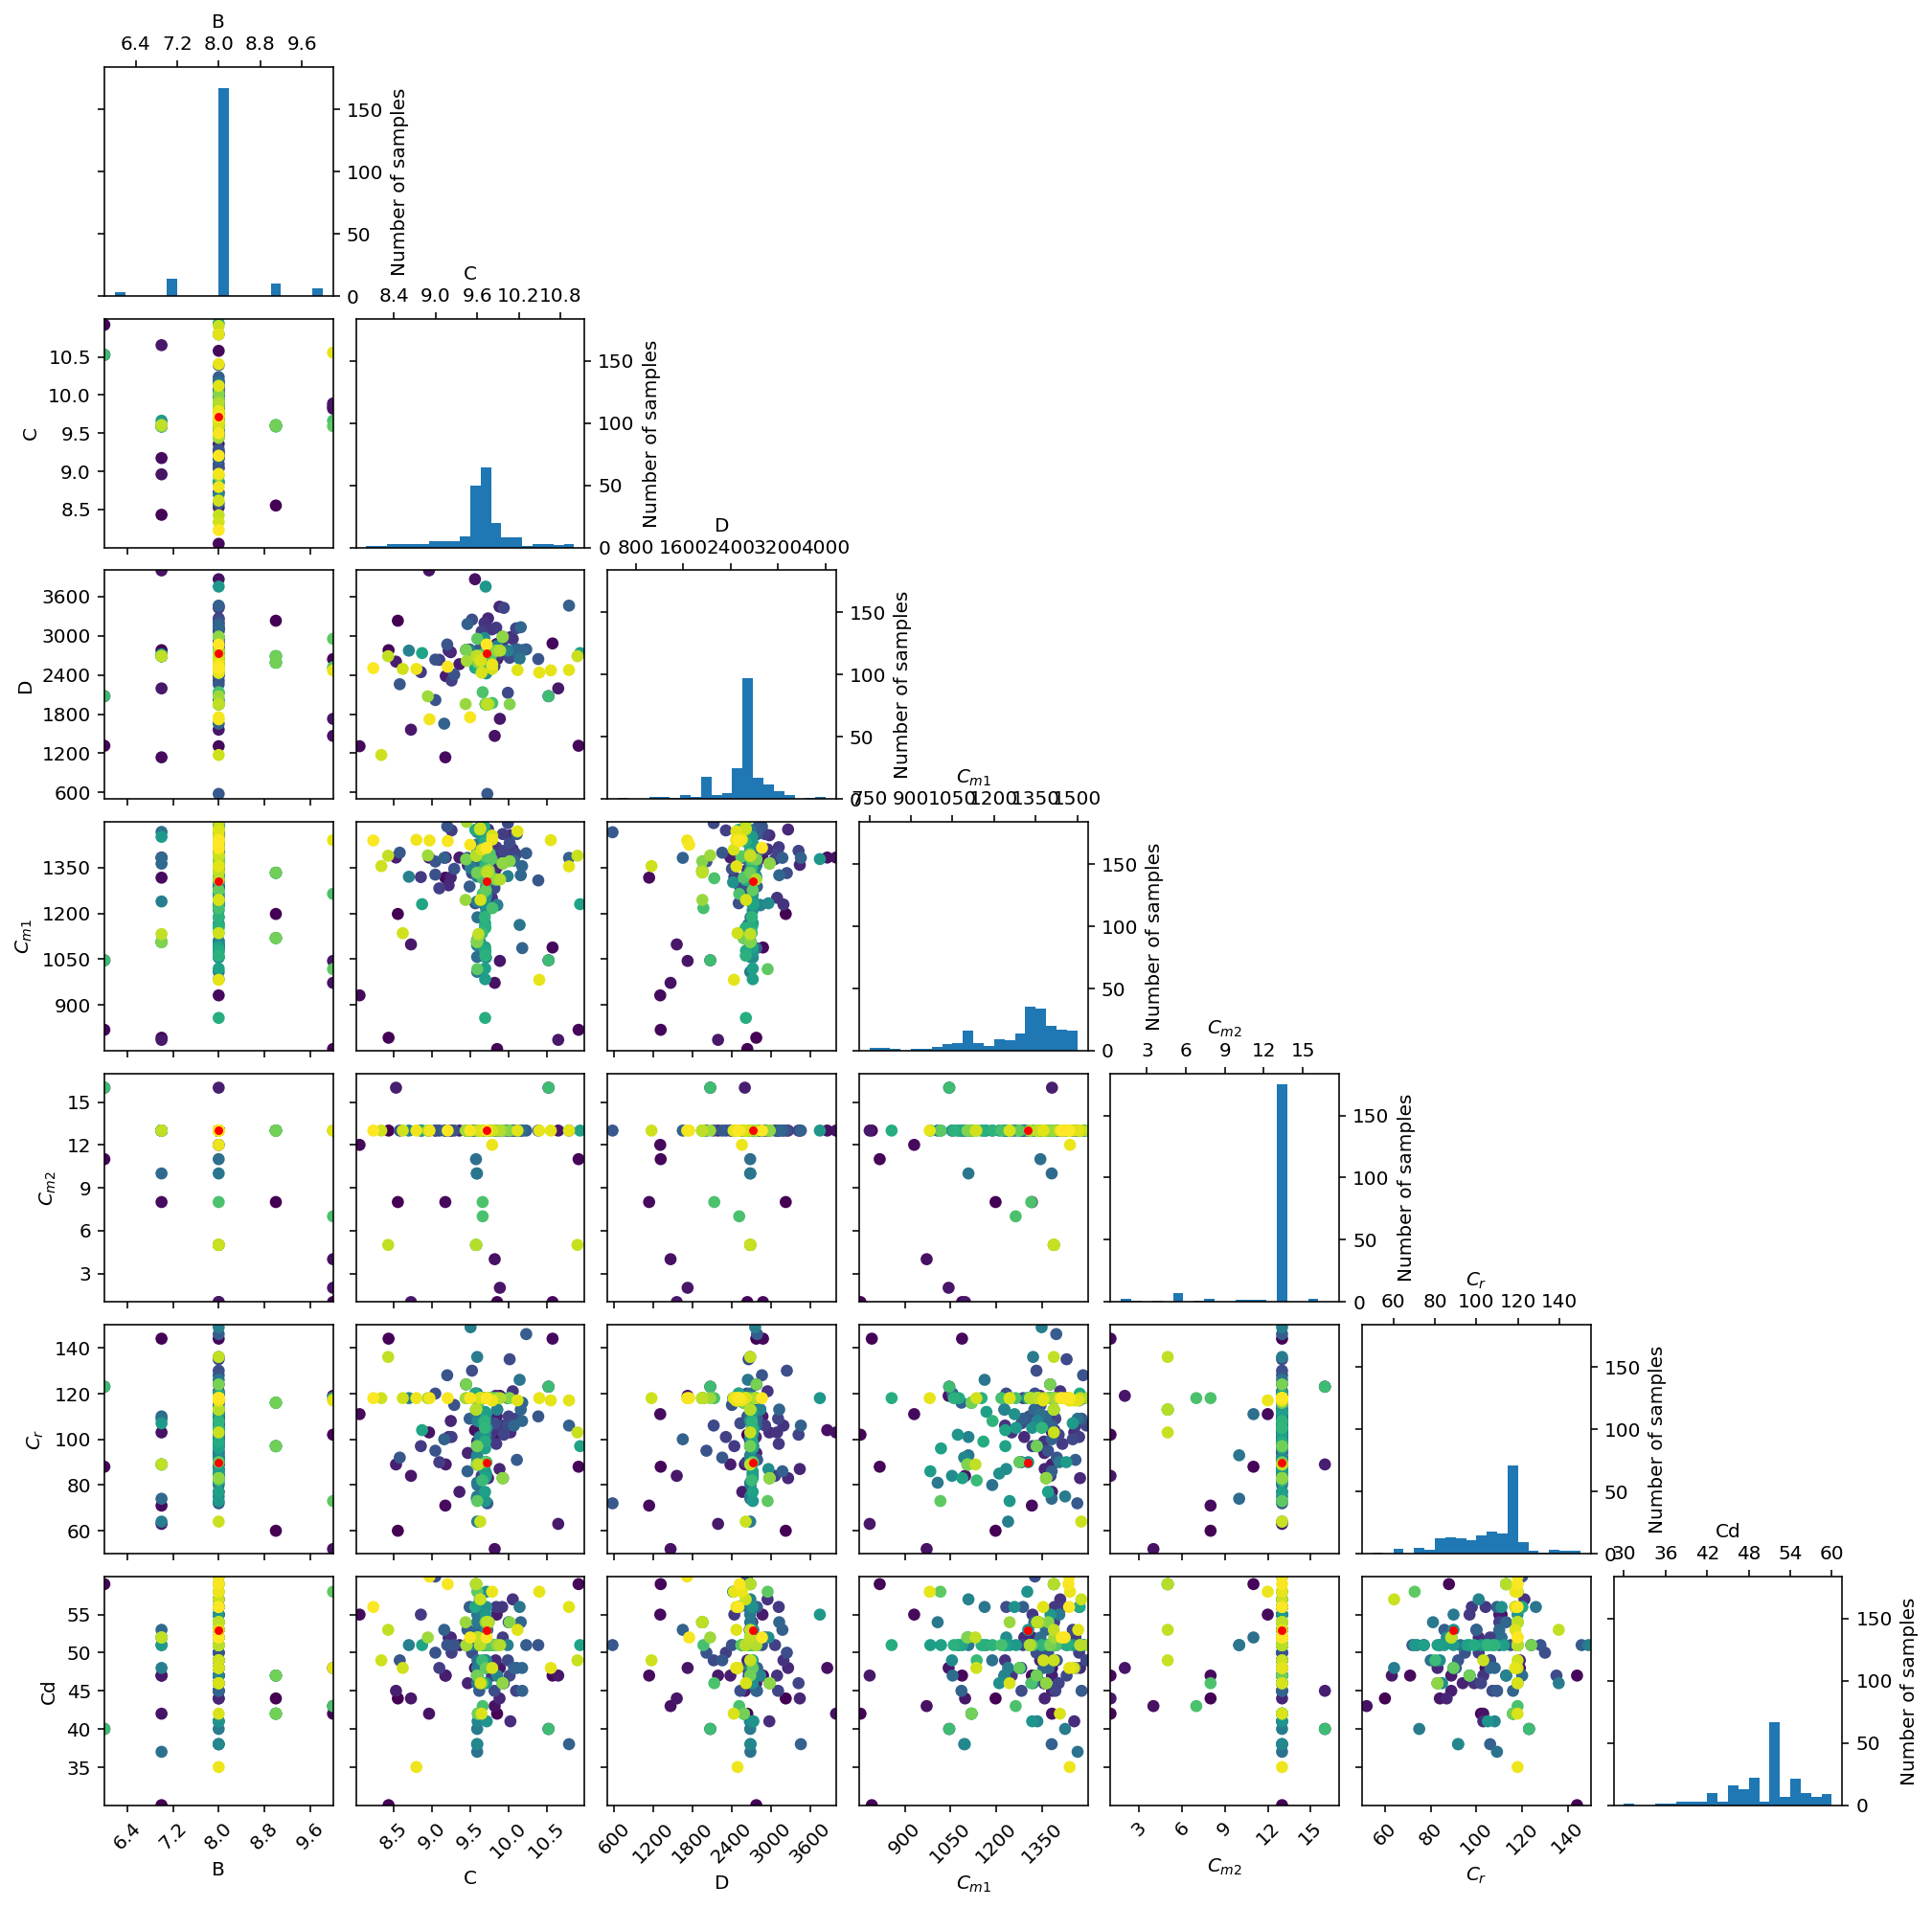

In [134]:
plot_evaluations(gp, dimensions=['B', 'C', 'D', '$C_{m1}$', '$C_{m2}$', '$C_r$', 'Cd'])
plt.show()

In [160]:
x=np.array(gp.x_iters)[:, 0]
y=np.array(gp.x_iters)[:, 1]
np.array([x, y]).T

array([[ 9.        ,  7.        , 10.        ,  6.        ,  8.        ,
         8.        ,  7.        ,  6.        ,  8.        , 10.        ,
         7.        , 10.        ,  8.        ,  7.        ,  8.        ,
         8.        ,  8.        ,  8.        ,  8.        ,  8.        ,
         8.        ,  8.        ,  8.        ,  8.        ,  8.        ,
         8.        ,  8.        ,  8.        ,  8.        ,  8.        ,
         8.        ,  8.        ,  8.        ,  8.        ,  8.        ,
         8.        ,  8.        ,  8.        ,  8.        ,  8.        ,
         8.        ,  8.        ,  8.        ,  8.        ,  8.        ,
         8.        ,  8.        ,  8.        ,  8.        ,  8.        ,
         8.        ,  8.        ,  8.        ,  8.        ,  8.        ,
         8.        ,  8.        ,  8.        ,  8.        ,  8.        ,
         8.        ,  8.        ,  8.        ,  8.        ,  8.        ,
         8.        ,  8.        ,  7.        ,  7. 

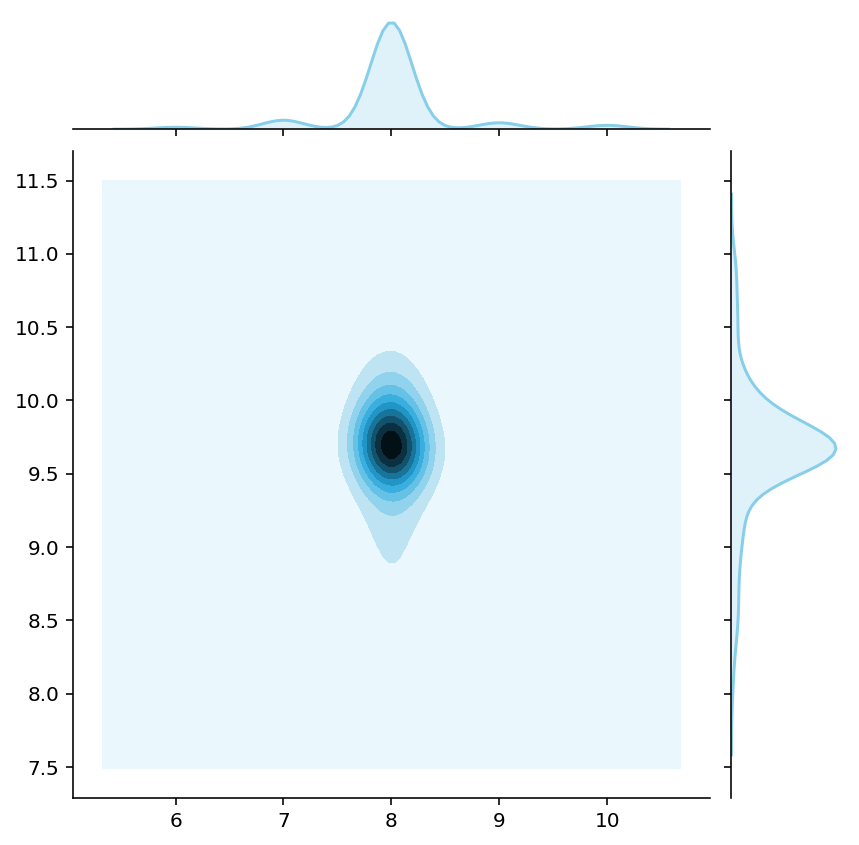

In [142]:
sns.jointplot(x=np.array(gp.x_iters)[:, 0], y=np.array(gp.x_iters)[:, 1], kind='kde', color="skyblue")

In [140]:
np.array(gp.x_iters)[:, 0]

array([ 9.,  7., 10.,  6.,  8.,  8.,  7.,  6.,  8., 10.,  7., 10.,  8.,
        7.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,
        8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,
        8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,
        8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,
        8.,  8.,  7.,  7.,  8.,  8.,  8.,  8.,  7.,  8.,  7.,  8.,  8.,
        8.,  9.,  8.,  8.,  8.,  8.,  7.,  8.,  8.,  8.,  9.,  8.,  8.,
        8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,
        8.,  8.,  8.,  8.,  7.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,
        9.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,
        8.,  9.,  8.,  9.,  9.,  8.,  7.,  6.,  8.,  9.,  8.,  8., 10.,
        8.,  8.,  8.,  8.,  8.,  8.,  8., 10.,  8.,  8.,  8.,  7.,  8.,
        9.,  9.,  8.,  8.,  8.,  7.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,
        8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  7

In [28]:
min(gp.func_vals)

43.35322205830113

## Model Blending

In [29]:
inf_eth = {
    # ddpg_model_1: [eth_1, eth_2, ..., eth_7]
    # .
    # .
    # .
    # ddpg_model_7: [eth_1, eth_2, ..., eth_7]
}

In [30]:
def run_inf(params):
    tf.reset_default_graph()
    with tf.Session() as sess:
        ddpg = DDPG(params, sess)
        summary = DDPGSummary(sess)
        sess.run(tf.global_variables_initializer())

        # load and restore weights
        model_path = os.path.join(
            params.base_path, "model",
            f"eps-{params.episode}*"
        )
        model_path = glob.glob(model_path)[0].split(".")
        model_path = ".".join(model_path[:2])
        summary.load_model(model_path)
        
        models = []
        for m_path in model_base_paths:
            params = Params.from_json(_m(m_path))
            eth = load_eth_model(params)
            eth = analyse(ddpg, eth, params)
            models.append(eth)
            
    return models

In [75]:
class DummyDDPG:
    """Dummy DDPG"""
    
    def __init__(self, actions):
        self.actions = list(actions)
    
    def predict(self, *args):
        return np.array([self.actions.pop(0)])
    

In [102]:
[e.inf_reward.sum() for e in inf_eth["02-03-2019/ddpg_run_5"]]

[-1999.999349414293,
 -1999.9987441431695,
 -1999.999349414293,
 -1999.9987441431695,
 -348.8197607674389,
 -1999.9987441431695,
 -1999.9988494143752]

In [41]:
episodes = [86, 53, 20, 69, 27, 15, 41]  # choose the best episodes
for ep, path in zip(episodes, model_base_paths):
    print(f"Analysing Path: {path}")
    params = Params.from_json(_m(path))
    params.base_path = _m(path)
    params.episode = ep
    inf_eth[path] = run_inf(params)

Analysing Path: 26-02-2019/ddpg_run_3
Analysing Path: 02-03-2019/ddpg_run_1
Analysing Path: 02-03-2019/ddpg_run_2
Analysing Path: 02-03-2019/ddpg_run_3
Analysing Path: 02-03-2019/ddpg_run_5
Analysing Path: 02-03-2019/ddpg_run_6
Analysing Path: 02-03-2019/ddpg_run_7


## Average and Weighted Average

In [86]:
def blend_average(inf_eth):
    print(f"Model \t\t\t Average \t\t Weighted Average")
    print(f"----- \t\t\t ------- \t\t ----------------")
    for i, path in enumerate(model_base_paths):
        actions = []
        scores = []
        for k, v in inf_eth.items():
            actions.append(v[i].sequence['1_delta'])
            scores.append(v[i].inf_reward.sum())
        actions = np.array(actions)
        scores = np.array(scores) + 2000
        
        averaged = np.average(actions, axis=0)
        weight_average = np.average(actions, axis=0, weights=scores)
        
        avg_ddpg = DummyDDPG(averaged)
        weight_ddpg = DummyDDPG(weight_average)
        
        params = Params.from_json(_m(path))
        eth = load_eth_model(params)
        
        analyse(avg_ddpg, eth, params)
        avg_score = eth.inf_reward.sum()
        
        analyse(weight_ddpg, eth, params)
        weight_score = eth.inf_reward.sum()
        
        print(f"{path} \t {avg_score} \t {weight_score}")        

In [87]:
blend_average(inf_eth)

Model 			 Average 		 Weighted Average
26-02-2019/ddpg_run_3 	 -1936.239450720129 	 -385.2968080161039
02-03-2019/ddpg_run_1 	 -1999.9979907471015 	 -1999.9562658574223
02-03-2019/ddpg_run_2 	 -1936.239450720129 	 -385.2968080161039
02-03-2019/ddpg_run_3 	 -1999.9979907471015 	 -1999.9562658574223
02-03-2019/ddpg_run_5 	 -1999.9992023522057 	 -1999.9999093607348
02-03-2019/ddpg_run_6 	 -1999.9979907471015 	 -1999.9562658574223
02-03-2019/ddpg_run_7 	 -1999.9993652209616 	 -401.2122119570304


## Optimal Weighted Average

In [121]:
def find_optimal_avg(inf_eth):
    print(f"Model \t\t\t Score \t\t Weights")
    score_labels = [f"model_{i}" for i in range(len(model_base_paths))]
    gp_models = []
    
    def _norm(a):
        return a / np.sum(a)
    
    def infer():
        actions = []
        scores = [Real(0, 1, name=n) for n in score_labels]
        
        for k, v in inf_eth.items():
            actions.append(v[i].sequence['1_delta'])
            
        @use_named_args(scores)
        def optimise(**params):
            weights = [params[k] for k in score_labels]
            w_avg = np.average(actions, axis=0, weights=weights)
            
            weight_ddpg = DummyDDPG(w_avg)
            
            analyse(weight_ddpg, eth, d_params)
            score = eth.inf_reward.sum()
            
            cost = -1 * score
            return cost
        
        gp = gp_minimize(
            optimise,
            scores, n_calls=300, n_jobs=2,
            random_state=43
        )
        return gp
            
    for i, path in enumerate(model_base_paths):
        d_params = Params.from_json(_m(path))
        eth = load_eth_model(d_params)
        gp = infer()
        gp_models.append(gp)
        
        print(f"{path} \t {min(gp.func_vals)} \t {gp.x}")
    
    return gp_models

In [122]:
gp_models = find_optimal_avg(inf_eth)

Model 			 Score 		 Weights


/home/zadiq/dev/venvs/dl/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/zadiq/dev/venvs/dl/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/zadiq/dev/venvs/dl/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/zadiq/dev/venvs/dl/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/zadiq/dev/venvs/dl/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("

26-02-2019/ddpg_run_3 	 601.6423614878503 	 [0.5174639950732981, 0.7440553339077087, 0.305568784278792, 0.04530209839251604, 0.14998275281967757, 0.058321601682543966, 0.9569762075117079]


/home/zadiq/dev/venvs/dl/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/zadiq/dev/venvs/dl/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/zadiq/dev/venvs/dl/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


02-03-2019/ddpg_run_1 	 660.0941796426799 	 [0.2941080302054078, 0.14648914156525752, 0.8429758946651046, 0.11913454834133999, 0.5652186183112101, 0.9440401816853562, 0.2266434192649917]


/home/zadiq/dev/venvs/dl/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/zadiq/dev/venvs/dl/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/zadiq/dev/venvs/dl/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/zadiq/dev/venvs/dl/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/zadiq/dev/venvs/dl/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("

02-03-2019/ddpg_run_2 	 601.6423614878503 	 [0.5174639950732981, 0.7440553339077087, 0.305568784278792, 0.04530209839251604, 0.14998275281967757, 0.058321601682543966, 0.9569762075117079]


/home/zadiq/dev/venvs/dl/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/zadiq/dev/venvs/dl/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/zadiq/dev/venvs/dl/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


02-03-2019/ddpg_run_3 	 660.0941796426799 	 [0.2941080302054078, 0.14648914156525752, 0.8429758946651046, 0.11913454834133999, 0.5652186183112101, 0.9440401816853562, 0.2266434192649917]


/home/zadiq/dev/venvs/dl/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/zadiq/dev/venvs/dl/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/zadiq/dev/venvs/dl/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/zadiq/dev/venvs/dl/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/zadiq/dev/venvs/dl/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("

02-03-2019/ddpg_run_5 	 435.444359090802 	 [0.1705220524705844, 0.4572063924000125, 0.22232203740277218, 0.20329927487909122, 0.15624803451185157, 0.9243816486241065, 0.6469980229916424]


/home/zadiq/dev/venvs/dl/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/zadiq/dev/venvs/dl/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/zadiq/dev/venvs/dl/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


02-03-2019/ddpg_run_6 	 660.0941796426799 	 [0.2941080302054078, 0.14648914156525752, 0.8429758946651046, 0.11913454834133999, 0.5652186183112101, 0.9440401816853562, 0.2266434192649917]


/home/zadiq/dev/venvs/dl/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


KeyboardInterrupt: 